In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

from models import MLP, CNN_MNIST
from utils import test
from imagenet_c import corrupt



device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {} device".format(device))

Using cuda device


In [2]:
class MNIST_noise(Dataset):
    def __init__(self, root, train, transform=None, target_transform=None):
        self.corruption = 'gaussian_noise'
        mnist = datasets.MNIST(
            root='../data',
            train=train,
            download=False,
        )
        self.images = mnist.data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load MNIST image
        image = self.images[idx, :, :]

        # Corrupt image and define label accordingly
        severity = np.random.randint(6)
        image = np.uint8(image)
        if severity > 0:
            image = corrupt(image, severity=severity, corruption_name=self.corruption)
        label = severity

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
train_data = MNIST_noise(
    root='../data',
    train=True,
    transform=ToTensor()
)
test_data = MNIST_noise(
    root='../data',
    train=False,
    transform=ToTensor()
)


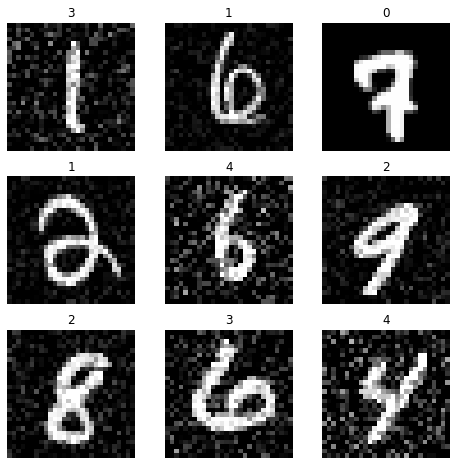

In [4]:
fig = plt.figure(figsize=(8, 8))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(label)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')

In [5]:
BATCH_SIZE = 64
NB_EPOCHS = 3
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [6]:
def train(dataloader, model, loss_function, optimizer):
    
    model.train()
    
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)
        
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_function(y_pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print('[{}/{}] loss: {}'.format(batch*len(X), size, loss))


In [7]:
model = CNN_MNIST(output_dim=6).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [8]:
test(test_dataloader, model, loss_function, device)
for e in range(1, NB_EPOCHS+1):
    print(f'Epoch {e}/{NB_EPOCHS}\n-------------------')
    train(train_dataloader, model, loss_function, optimizer)
    test(test_dataloader, model, loss_function, device)

Test error: 1.7925440073013306
Accuracy 0.1656

Epoch 1/3
-------------------
[0/60000] loss: 1.8410367965698242
[6400/60000] loss: 0.4690409302711487
[12800/60000] loss: 0.5337477326393127
[19200/60000] loss: 0.4491751492023468
[25600/60000] loss: 0.17771273851394653
[32000/60000] loss: 0.01065049134194851
[38400/60000] loss: 0.027496321126818657
[44800/60000] loss: 0.41138723492622375
[51200/60000] loss: 0.003944619558751583
[57600/60000] loss: 0.3394741714000702
Test error: 0.007306613028049469
Accuracy 0.9983

Epoch 2/3
-------------------
[0/60000] loss: 0.024344755336642265
[6400/60000] loss: 0.015213760547339916
[12800/60000] loss: 0.08065447956323624
[19200/60000] loss: 0.20297804474830627
[25600/60000] loss: 0.016077836975455284
[32000/60000] loss: 0.01431960053741932
[38400/60000] loss: 0.0033654209692031145
[44800/60000] loss: 0.0044434997253119946
[51200/60000] loss: 0.2433084398508072
[57600/60000] loss: 0.024547340348362923
Test error: 0.010353261604905128
Accuracy 0.9964

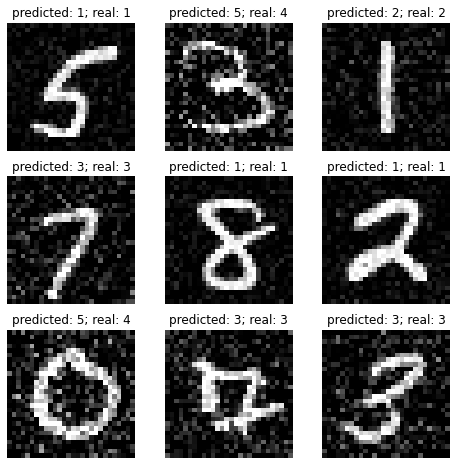

In [9]:
model.eval()

fig = plt.figure(figsize=(8, 8))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    with torch.no_grad():
        prediction = model(img[None,:,:,:].to(device)).detach().cpu()
        predicted_label = np.argmax(prediction)
    fig.add_subplot(rows, cols, i)
    plt.title(f'predicted: {predicted_label}; real: {label}')
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')

In [10]:
torch.save(model.state_dict(), f'CNN_noise_MNIST_weights_{datetime.now().strftime("%Y%m%d_%H%M")}.pth')